In [1]:
from pathlib import Path
from omegaconf import OmegaConf
import torch
import numpy as np
from matplotlib import pyplot as plt
import cv2

from gluefactory.datasets import get_dataset
from gluefactory.utils.tensor import batch_to_device
from gluefactory.geometry.gt_generation import gt_matches_from_pose_depth, gt_matches_from_homography
from gluefactory.models import get_model


In [2]:
def draw_keypoints_cv(image, kps, color = (0, 255, 0), select_kp = None):
  if image.shape[0] == 3:  # RGB
    scale = image.new_tensor([0.299, 0.587, 0.114]).view(3, 1, 1)
    image = (image * scale).sum(0)
    print(image.shape)
  image = image.detach().cpu().numpy()
  image = (image * 255).astype(np.uint8)
  kps = kps.detach().cpu().numpy()
    
  cv_kps= [cv2.KeyPoint(kp[0], kp[1], 1) for kp in kps]
  out_img = cv2.drawKeypoints(image, cv_kps, None, color=color, flags=0)

  if select_kp is not None:
    for kp in select_kp:
      cv2.circle(out_img, (int(kps[kp][0]), int(kps[kp][1])), 5, (255, 0, 0), -1)

  return out_img

In [3]:
def draw_stats(data):
    # arg: data Nx2
    print(f'Max and Min and Median x: {data[:, 0].max()}, {data[:, 0].min()}, {data[:, 0].median()}')
    print(f'Max and Min and Median y: {data[:, 1].max()}, {data[:, 1].min()}, {data[:, 1].median()}')
    data= data.numpy()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # draw x, y value as bar chart
    ax1.bar(np.arange(len(data)), data[:, 0])
    ax1.set_title('X values')
    ax2.bar(np.arange(len(data)), data[:, 1])
    ax2.set_title('Y values')

In [35]:
conf = OmegaConf.load(file_="../gluefactory/configs/superpoint+simpleglue_homography_debug.yaml")
# conf = OmegaConf.load(file_="../gluefactory/configs/superpoint+simpleglue_megadepth_debug.yaml")

In [36]:
data_conf = (conf.data)
dataset = get_dataset(data_conf.name)(data_conf)

[08/30/2025 00:40:31 gluefactory.datasets.base_dataset INFO] Creating dataset HomographyDataset
[08/30/2025 00:40:31 gluefactory.datasets.homographies INFO] Found 8 images in list file.


In [37]:
train_loader = dataset.get_data_loader("train", distributed=False)
itr = iter(train_loader)


In [38]:
extractor = get_model(conf.model.extractor.name)(conf.model.extractor)

In [39]:
gt_matcher = get_model(conf.model.ground_truth.name)(conf.model.ground_truth)

In [40]:
data = next(itr)   # first batch

pred0 = extractor(data["view0"])
pred1 = extractor(data["view1"])
pred = {
    **{k + "0": v for k, v in pred0.items()},
    **{k + "1": v for k, v in pred1.items()},
}

gt_pred = gt_matcher({**data, **pred})

In [41]:
res0_1_sq = gt_pred["res0_1_sq"][0]
res1_0_sq = gt_pred["res1_0_sq"][0]

dist0_min = torch.sum(res0_1_sq, -1).min(-1).values
best_idx0 = torch.argmin(dist0_min)
worst_idx0 = torch.argmax(dist0_min)
dist1_min = torch.sum(res1_0_sq, -1).min(-1).values
best_idx1 = torch.argmin(dist1_min)
worst_idx1 = torch.argmax(dist1_min)



Max and Min and Median x: 12309.078125, 7.714707317063585e-05, 2469.720703125
Max and Min and Median y: 10189.76953125, 4.747619095724076e-05, 918.429931640625
Max and Min and Median x: 15086.162109375, 0.0001750919473124668, 2026.191162109375
Max and Min and Median y: 12514.2431640625, 6.276836938923225e-05, 976.0673217773438


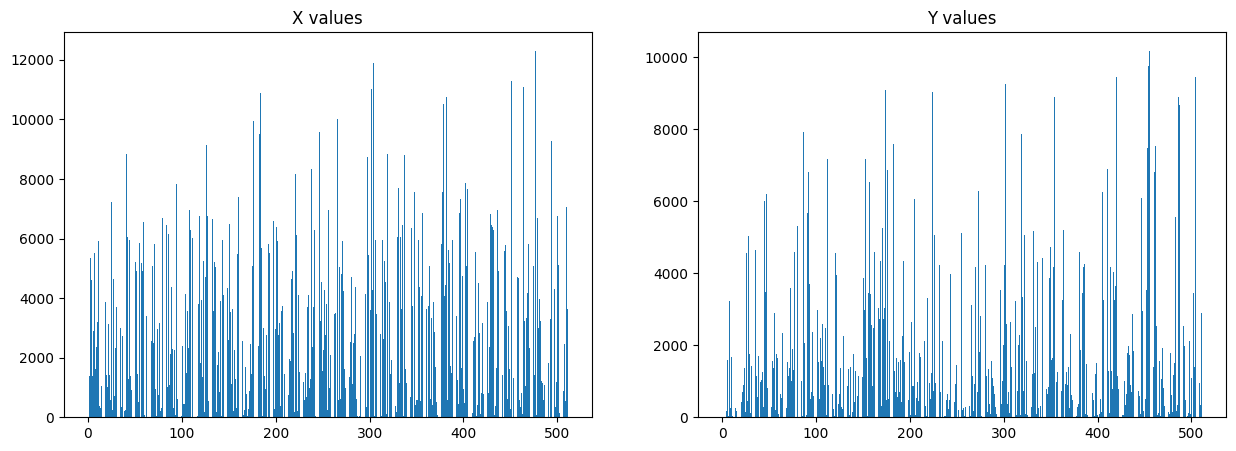

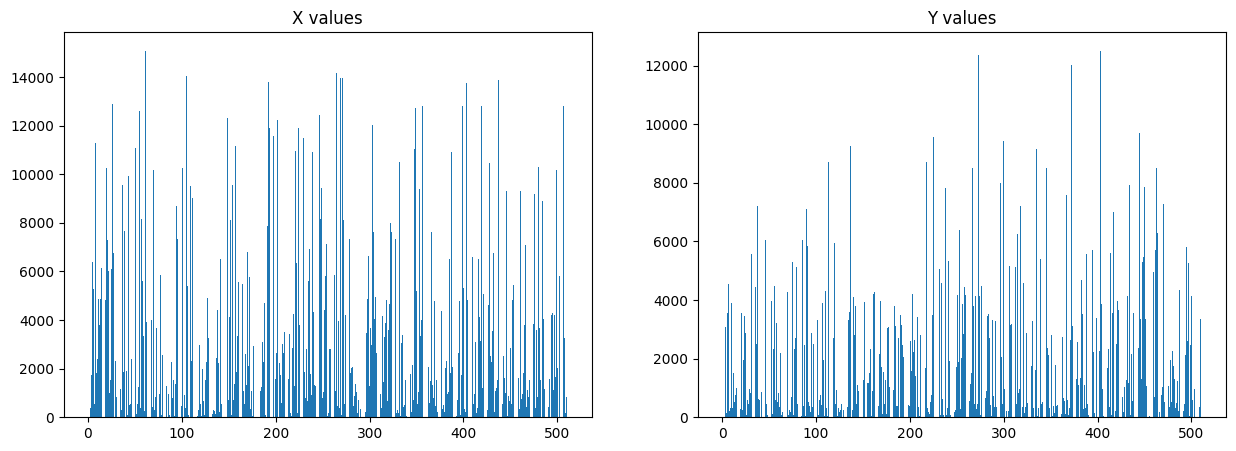

In [42]:
draw_stats(res0_1_sq[best_idx0, ...])
draw_stats(res1_0_sq[best_idx1, ...])

Max and Min and Median x: 40000.0, 40000.0, 40000.0
Max and Min and Median y: 40000.0, 40000.0, 40000.0
Max and Min and Median x: 40000.0, 40000.0, 40000.0
Max and Min and Median y: 40000.0, 40000.0, 40000.0


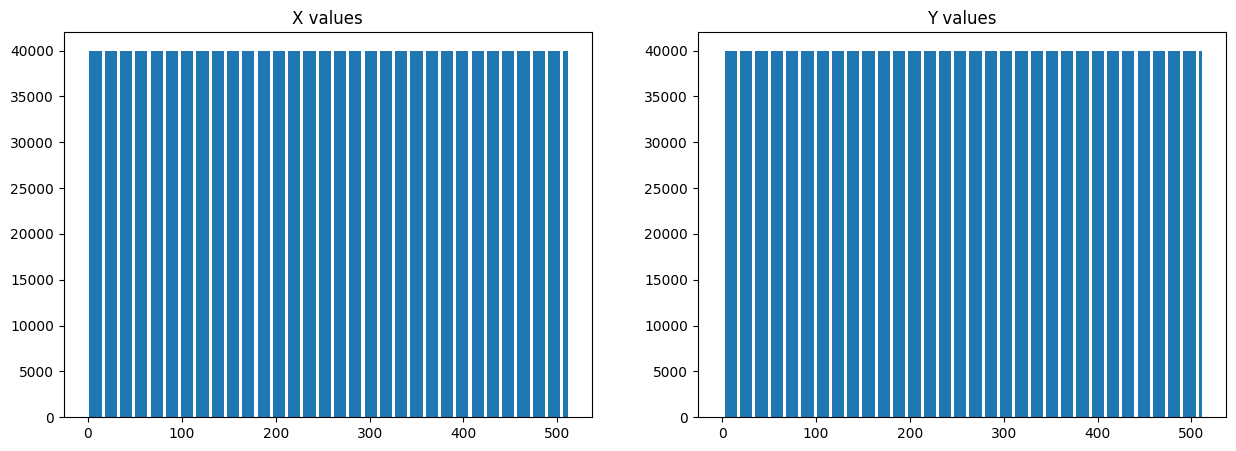

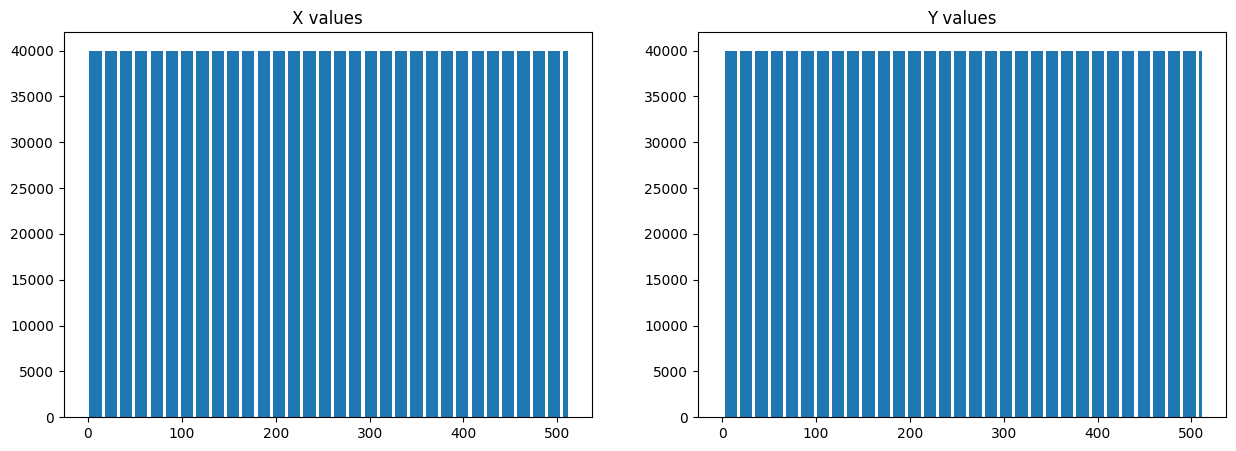

In [43]:
draw_stats(res0_1_sq[worst_idx0, ...])
draw_stats(res1_0_sq[worst_idx1, ...])

torch.Size([480, 640])


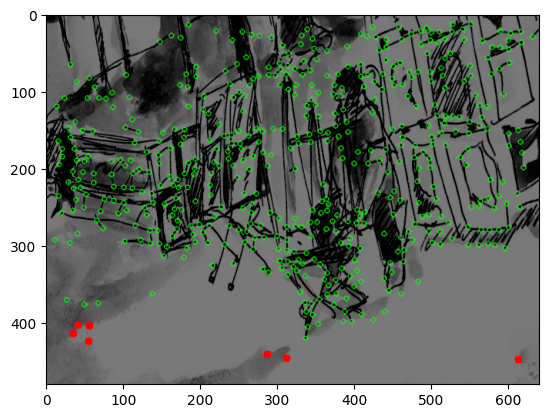

In [44]:
valid0 = gt_pred["valid0_1"][0]
occluded_kp0s = torch.where((dist0_min==80000) & valid0)[0]
img0 = draw_keypoints_cv(data['view0']['image'][0], pred['keypoints0'][0], color=(0,255,0), select_kp=occluded_kp0s)
plt.imshow(img0)
plt.show()

In [45]:
data['view0']['image'][0].shape

torch.Size([3, 480, 640])

torch.Size([480, 640])


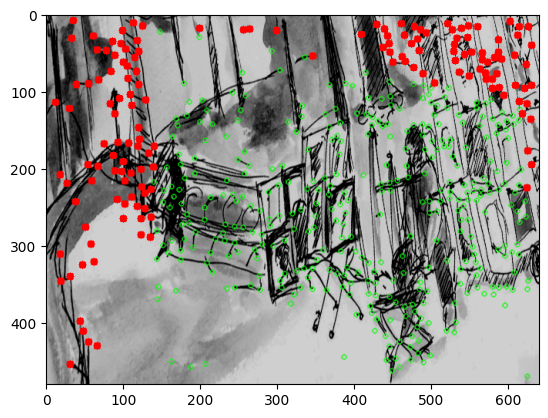

In [46]:
valid1 = gt_pred["valid1_0"][0]
occluded_kp1s = torch.where((dist1_min==80000) & valid1)[0]
img1 = draw_keypoints_cv(data['view1']['image'][0], pred["keypoints1"][0], color=(0,255,0), select_kp=occluded_kp1s)
plt.imshow(img1)
plt.show()


In [47]:
from gluefactory.models.matchers.simpleglue import PositionEmbeddingSine
import torch

ImportError: cannot import name 'PositionEmbeddingSine' from 'gluefactory.models.matchers.simpleglue' (/mnt/lustre/work/bamler/zxiao29/haolong/glue-factory/gluefactory/models/matchers/simpleglue.py)

In [ ]:
mask = torch.ones((1, 480, 600), dtype=torch.bool)  # Example mask, adjust size as needed
pos_embed = PositionEmbeddingSine(num_pos_feats=128, normalize=True)
kpts = torch.ones((2, 100, 2))
size = torch.tensor([480, 600], dtype=torch.float32).unsqueeze(0)
pe = pos_embed(kpts, size)
print(pe.shape)

kpts shape and size shape torch.Size([2, 100, 2]) torch.Size([1, 2])
torch.Size([2, 100, 256])


In [ ]:
torch.Size([1, 480, 600]) torch.Size([1, 480, 600]) torch.Size([64])
torch.Size([1, 128, 480, 600])

SyntaxError: invalid syntax (3295899793.py, line 1)